# Feature detection

In [2]:
import numpy as np
import scipy.io as sio
import scipy.signal as signal
import scipy.stats
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import copy

# Required for interactive plots in DataSpell
# import matplotlib
# matplotlib.use("nbagg")

## Generate data

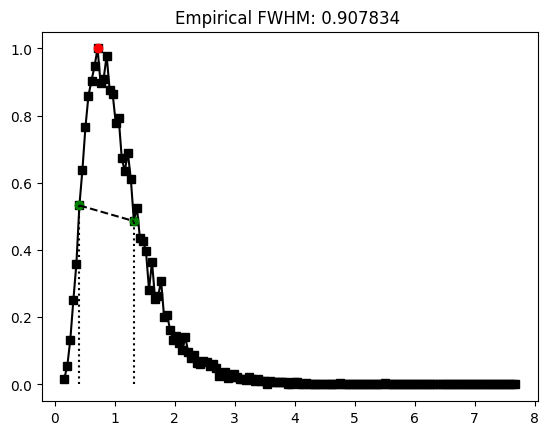

In [41]:
## example with asymmetric shape

# generate asymmetric distribution
fx, x = np.histogram(np.exp(.5*np.random.randn(10000,1)),150)
x = x[0:-1]

# normalization necessary here!
fxNorm = fx/np.max(fx)

## Helper function to plot the FWHM
def calculateAndPlotFWHM(x, distribution: np.ndarray) -> float:
    # plot the function
    plt.plot(x, distribution, 'ks-')

    # find peak point
    peakpnt = np.where( distribution==np.max(distribution) )[0][0]

    # find 50% PREpeak point
    prepeak = np.argmin((distribution[:peakpnt]-.5)**2)

    # find 50% POSTpeak point
    pstpeak = np.argmin((distribution[peakpnt:-1]-.5)**2)
    pstpeak = pstpeak + peakpnt  # adjust

    # compute empirical FWHM
    fwhmE = x[pstpeak] - x[prepeak]

    # plot the points
    plt.plot(x[peakpnt],distribution[peakpnt],'ro')
    plt.plot(x[prepeak],distribution[prepeak],'go')
    plt.plot(x[pstpeak],distribution[pstpeak],'go')

    # plot line for reference
    plt.plot([x[prepeak],x[pstpeak]],[distribution[prepeak], distribution[pstpeak]],'k--')
    plt.plot([x[prepeak],x[prepeak]],[0, distribution[prepeak]],'k:')
    plt.plot([x[pstpeak],x[pstpeak]],[0, distribution[prepeak]],'k:')

    plt.title('Empirical FWHM: %g ' %fwhmE)
    return fwhmE

calculateAndPlotFWHM(x, fxNorm)
plt.show()

# Issue
We want to measure the FWHM metric (with at 50% height). However, the data is too sparse and noisy to confedently determine this value.

Solution: Smooth and interpolate (upsample) the data. Lets start with interpolating the signal.

(150,)
(150,)
(3000,)


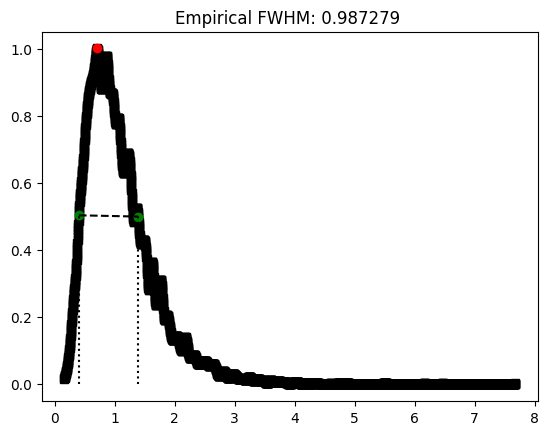

In [42]:
upsampleFactor = 20

newX = np.linspace(x[0], x[-1], x.size * upsampleFactor)

print(x.shape)
print(fxNorm.shape)
print(newX.shape)

uFxNorm = griddata(x, fxNorm, newX, method='cubic')

calculateAndPlotFWHM(newX, uFxNorm)
plt.show()

# Smooting
Now, just upsaming the signal already improved the calculation. However, the line should be smooth as well.

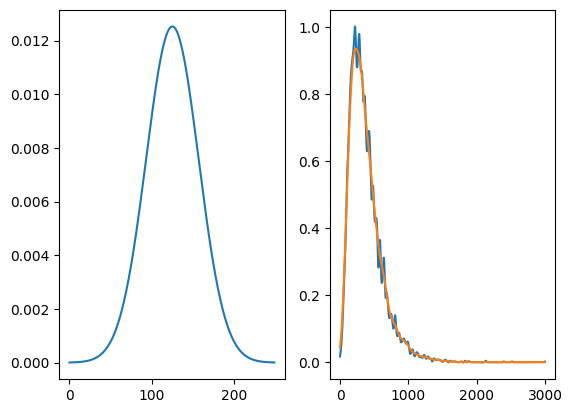

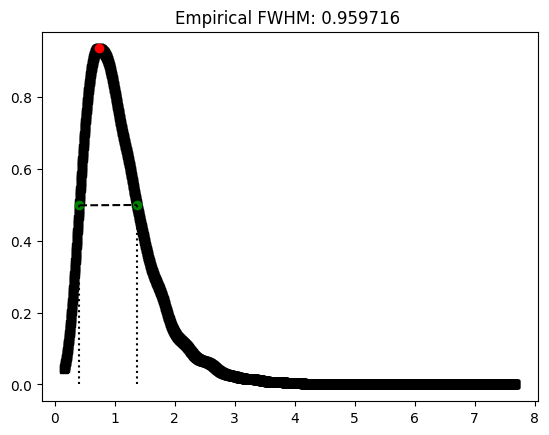

In [46]:
## create the Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 75
k = 125
gtime = np.arange(-k,k)

# create Gaussian window and normalize to unit energy
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )
gauswin = gauswin / np.sum(gauswin)

filteredSignal = np.convolve(uFxNorm, gauswin, 'same')

plt.subplot(121)
plt.plot(gauswin)

plt.subplot(122)
plt.plot(uFxNorm)
plt.plot(filteredSignal)

plt.figure()
calculateAndPlotFWHM(newX, filteredSignal)
plt.show()

Much smoother and more consistent!